# Modelos Generativos Autorregresivos


## Andrés Ferragut


### Basado en el material de:

  * "[Probabilistic Machine Learning: Advanced Topics](https://probml.github.io/pml-book/book2.html)", Kevin P. Murphy, MIT Press, 2023.
  * "[Deep Generative Modeling](https://link.springer.com/book/10.1007/978-3-030-93158-2)", Jakub M. Tomczak, Springer, 2022.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from pytorch_model_summary import summary

## Modelos generativos

**Idea:** Ajustar una densidad $p(\mathbf{x})$ que permita generar de manera eficiente muestras de la variable $\mathbf{x}$.

**Problema:** Típicamente $\mathbf{x}$ vive en un espacio complicado. Ejemplo: imágenes ByN, $\mathbf{x}\in\{0,\ldots,255\}^T$ con $T$ grande (píxeles). No todas los $\mathbf{x}$ son igualmente relevantes.

### Sabores:

  * **No condicional:** Ajusto $p_\theta(\mathbf{x})$, genero nuevas muestras en el espacio completo.
  * **Condicional:** Ajusto $p_\theta(\mathbf{x}\mid \mathbf{c})$, siendo $\mathbf{c}$ un conjunto de *prompts* que dirigen el sampling hacia el tipo de salida que deseo obtener.

## Modelos generativos profundos (Deep generative models)

* Buscan aplicar redes neuronales profundas para ajustar una densidad condicional $p(\mathbf{x}\mid \mathbf{z})$ desde un conjunto (más pequeño) de variables *latentes* $\mathbf{z}$.

* Combinado con una distribución "a priori" $p(\mathbf{z})$ (postulada), generamos muestras de $p(\mathbf{x}) = p(\mathbf{x}\mid \mathbf{z})p(\mathbf{z})$.

## Tipos de DGM

![tipos](dgm.png)

## Modelos autorregresivos (ARM)

La idea básica es descomponer $p(\mathbf{x})$ como:

$$p(\mathbf{x}) = p(x_1)p(x_2\mid x_1)p(x_3\mid x_1,x_2) \ldots = \prod_{i=1}^T p(x_t\mid x_{1:t-1})$$

siendo $x_t$ la coordenada $t$ de $\mathbf{x}$, $x_{1:t-1}$ las primeras $t-1$ coordenadas, y $p(x_1\mid x_{1:0})\equiv p(x_1)$ la marginal de la primera coordenada.


**Problema:** si bien la descomposición es válida, $p(x_t\mid x_{1:t-1})$ es cada vez más compleja si dejamos que dependa de toda la historia pasada.

## Objetivo

En general el objetivo es maximizar la verosimilitud logarítmica de lo anterior, que corresponde a:

$$ \log p(\mathbf{x}) = \sum_{i=1}^T \log\left(p(x_t\mid x_{1:t-1})\right)$$


### Simplificaciones:

* Modelo markoviano: suponer $p(x_t\mid x_{1:t-1}) = p(x_t\mid x_{t-1})$ (o AR(1)).
* AR($k$):   suponer $p(x_t\mid x_{1:t-1}) = p(x_t\mid x_{t-k:t-1})$
* HMM: Usar un estado latente, tal que $z_t$ es una cadena de Markov, y $p(x_t\mid x_{1:t-1})= p(x_t\mid z_t)$. Esto produce un modelo markoviano escondido.

* RNN: Usar un estado latente $z_t$ y modelar:
    $$p(x_t\mid  x_{1:t-1}) = p(x_t\mid z_t)f(z_t\mid x_{1:t-1})$$

Es decir, comprimimos la historia en un estado latente $z_t$ que es función (no lineal) determinística de la historia. Esto produce lo que se denomina una *red neuronal recurrente*

## Deep autoregresive models

**Idea:**

 * Mantenerse en el modelo ARM de la ecuación anterior...
 * Pero plantear una forma funcional (por ejemplo red neuronal) para las condicionales:
 
 $$ p(x_t\mid x_{1:t-1}) $$
 
En lugar de hacer hipótesis de independencia condicional, o comprimir el pasado en un estado latente $z$ (estadístico suficiente del pasado), aprender un mapa compacto del pasado hacia el futuro.

## Deep autoregresive models

### Ventajas

 * Se puede calcular (y optimizar en los parámetros) la verosimilitud exacta $p(\mathbf{x})$.
 * Se puede generar datos nuevos de manera recursiva...
 
### Desventajas

 * Al ser recursivos, la generación puede ser lenta.
 * Al no haber una representación compacta, es difícil *extraer* características como hacemos con las variables latentes.

## Ejemplo: Neural autoregressive density estimators (NADE)

Propuestos por Larochelle & Murray [[LM11]](https://proceedings.mlr.press/v15/larochelle11a/larochelle11a.pdf).

**Idea:** Si mis observaciones $x_t\in\{0,1\}$ entonces modelo:

$$\begin{cases}\theta_t = P(x_t=1\mid x_{1:t-1}) = \sigma(b_t + W^h_t h_t), \\ h_t = \sigma(\mathbf{c} + W^\theta_t \theta_{1:t-1}).\end{cases}$$

Similar a una red neuronal recurrente. $h_t$ actúa como una variable de estado oculta. Las matrices $W^h_t$ y $W^\theta_t$ dependen del tiempo. Ojo que $W^\theta$ crece en tamaño con $t$.

## Ejemplo: Real valued neural autoregressive density estimator (RNADE)

Propuestos por Uria, Murray & Larochelle [ULM13](https://arxiv.org/abs/1306.0186):

**Idea:** Más en general, si $x_t$ es a valores reales, entonces modelo $x_t$ como una mezcla de gaussianas:

$$p(x_t\mid x_{1:t-1}) = \sum_{k=1}^K \pi_{t,k} \mathcal{N}(x_t\mid \mu_{t,k}, \sigma^2_{t,k})$$

Con los parámetros de las gaussianas:

$$(\pi_t,\mu_t,\sigma_t) = f_t(x_{1:t-1}\mid \theta_t)$$

donde $f$ es una red neuronal (en principio arbitraria, pero...).

## Ejemplo: RNADE, detalles

Más concretamente [ULM13](https://arxiv.org/abs/1306.0186) propone la siguiente estructura:

Activaciones:
$$a_1 = c, \quad a_{t+1} = a_t + x_t^T W_t$$
    
    
Variables latentes:

$$h_t = \mathrm{RelU}(\rho_t a_t)$$
    
Parámetros de la mezcla gaussiana:

* *Mixing fractions:* $$\pi_t = \mathrm{softmax}(V^\pi_t h_t + b^\pi_t).$$

* *Means:* $$\mu_t = V^{\mu}_t h_t + b^{\mu}_t.$$

* *Standard deviations:* $$\sigma_t = \exp(V^{\sigma}_t h_t + b^{\sigma}_t).$$

**Parámetros a entrenar:** $c$, $W_t$, $\rho_t$, $V^\pi_t$, $V^\mu_t$, $V^{\sigma}_t$, $b^\pi_t$, $b^{\mu}_t$, $V^\sigma_t$.

## Limited memory (Tomczak 2.2.1)

Esto corresponde a un modelo $AR(k)$ no lineal. A modo de ejemplo se presenta el siguiente modelo:

$$p(\mathbf{x}) = p(x_1)p(x_2\mid x_1) \prod_{t=3}^T p(x_t\mid x_{t-1},x_{t-2}).$$

Luego se usa una red neuronal simple para modelar $p(x_t\mid x_{t-1},x_{t-2})$.

### Ejemplo:

Si $x\in \mathcal{X} = \{0,\ldots,255\}$ entonces $p(x_t\mid x_{t-1},x_{t-2})$ es una distribución de probabilidad $\theta_t$ en $\mathcal{X}$. Podemos hacer un modelo de la forma:

$$[x_{t-1},x_{t-2})] \to \mathrm{Dense}(2,M) \to \mathrm{ReLU} \to \mathrm{Dense}(M,256) \to \mathrm{softmax} \to \theta_d.$$

O bien en ecuaciones:

$$\begin{cases} h_t = \mathrm{ReLU}\left(W \begin{bmatrix}x_{t-1}\\x_{t-2} \end{bmatrix}\right)\\ 
\theta_t = \mathrm{softmax}( V h_t) \end{cases}$$

Con $W$ de $M\times 2$ y $V$ de $256\times M$, siendo $M$ el número de variables latentes.

A entrenar: $W, V$. $M$ es un hiperparámetro.

### Ejemplo: gráficamente

![AR2](neural_ar2.png)

### Problemas

* Estamos usando un único modelo homogéneo (dado por $W$ y $V$) para codificar todas las dependendcias.
* La ventaja es que requiere pocos parámetros, pero asume cierta estacionariedad de los datos.
* No es claro cómo elegir la memoria $M$ del modelo.


**Pregunta:** ¿sería posible cambiar $W$ y $V$ por $W_t$, $V_t$?

## Long range memory y RNN (Tomczak 2.2.2)

La segunda idea es utilizar una red neuronal recurrente, es decir modelar:

$$p(x_t\mid x_{1:t-1}) = p(x_t \mid \mathrm{RNN}(x_{t-1},h_{t-1}))$$

Siendo $\mathrm{RNN}(x_{t-1},h_{t-1})$ una red neuronal recurrente, y $h_t$ un *hidden context* o variable de estado.

### RNN: descripción gráfica.

![RNN](rnn.png)

### RNN: ecuaciones

Las ecuaciones para el mismo modelo que antes serían:

$$\begin{cases}
h_t  = \sigma\left(W h_{t-1} + V x_{t-1} + b \right) \\
\theta_t = \mathrm{softmax}(h_t)
\end{cases}$$

con $\sigma$ una no linealidad a elegir, y $W$, $V$, $b$ parámetros a entrenar.

**Pregunta:** ¿podemos cambiar por $W_t$, $V_t$, $b_t$?

## Problemas: vanishing and exploding gradients

* La parametrización es eficiente, pero presenta los mismos problemas que antes (homogeneidad).
* Es secuencial por lo que es lenta de generar nuevas secuencias.
* Aparecen las potencias de $V$ y $W$ en el gradiente, por lo que sin reescalar, si los valores propios de $W$ y $V$ se alejan de $1$ el gradiente tiende a $0$ o $\infty$ (vanishing and exploding gradients).

## (Causal) Convolutional Neural Networks.

Las redes *convolucionales* surgen como una alternativa para capturar dependencias de largo plazo: útiles en imágenes y análisis de texto.

**Definición (en dimensión 1):**

$$o_t = \sigma\left(\sum_{k} W_k x_{t-k} + b\right)$$

**Problema:** en principio $W_k$ puede usar valores futuros de $x_t$ para calcular $o_t$, por lo que a los efectos de generar un modelo *generativo recursivo* no nos sirve.

**Solución:** usar solo convoluciones causales...

## Ejemplo (Tomczak, 2.2.3):

En el libro, Tomczak define dos tipos de convoluciones causales:

 * **Tipo A:** se calcula $o_t$ usando solo valores *anteriores* de $x_t$.
 * **Tipo B:** se calcula $o_t$ usando valores anteriores y el valor actual de $x_t$.
 
No podemos usar solo tipo B, porque dependería de la muestra actual (a generar), pero podemos hacer *stacking* de capas tipo A y B, comenzando por tipo A.

A su vez propone usar diferentes escalas de **dilatación** (dilation) para ir capturando las dependencias de largo plazo.

## Ejemplo CNN: representación gráfica.

![deep_cnn](deep_cnn.png)

### Implementación en PyTorch

In [2]:
class CausalConv1d(nn.Module):
    """
    A causal 1D convolution.
    """

    def __init__(self, in_channels, out_channels, kernel_size, dilation, A=False, **kwargs):
        super(CausalConv1d, self).__init__()

        # attributes:
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A
        
        self.padding = (kernel_size - 1) * dilation + A * 1

        # module:
        self.conv1d = torch.nn.Conv1d(in_channels, out_channels,
                                      kernel_size, stride=1,
                                      padding=0,
                                      dilation=dilation,
                                      **kwargs)

    def forward(self, x):
        x = torch.nn.functional.pad(x, (self.padding, 0))
        conv1d_out = self.conv1d(x)
        if self.A:
            return conv1d_out[:, :, : -1]
        else:
            return conv1d_out

## Ejemplo: un datasets de dígitos reducido

Para tener un ejemplo sencillo, se propone utilizar un dataset de imágenes de dígitos:

 * El dataset `digits` de `SciPy` consiste en $\approx 1500$ imágenes de dígitos.
 * Cada imagen tiene 17 niveles de gris. Es decir $\mathcal{X} = \{0,\ldots,16\}$.
 * Las imágenes son de $8\times 8$ píxeles.

In [3]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

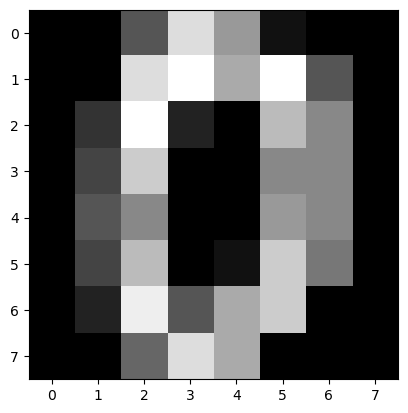

In [17]:
plottable_image = np.reshape(Digits()[0], (8, 8))
plt.imshow(plottable_image, cmap='gray')

## Función objetivo: máxima verosimilitud

Si tenemos $\mathcal{D} = \{\mathbf{x}_1,\ldots,\mathbf{x}_N\}$ datos, buscamos maximizar la verosimilitud dada por:

$$\mathcal{L} = \sum_{n} p(\mathbf{x}_n) = \sum_n\left(\sum_t \log p(x_{n,t}\mid x_{n,[1:t-1]})\right)$$

Para cada imagen $n$ anterior, $p(x_{n,t}\mid x_{n,[1:t-1]})$ corresponde a nuestra distribución categórica, por lo que:

$$p(x_{n,t}\mid x_{n,[1:t-1]}) = \log\left(\prod_{l=1}^L \theta_{t,l}^{\mathbf{1}_{\{x_t=l\}}}  \right) = \sum_{l=1}^L \mathbf{1}_{\{x_t=l\}}\log (\theta_{t,l}).$$

Por lo tanto la función objetivo es aditiva:

$$\mathcal{L} = \sum_{n=1}^N \sum_{t=1}^{T} \sum_{l=1}^L \mathbf{1}_{\{x_t=l\}}\log\left( \theta_{t,l}\right)$$

con $\theta_{t,\cdot}$ el vector de probabilidades salida del modelo en tiempo $t$.

$N=$ cantidad de imágenes, $T=$ cantidad de píxeles, $L=$ niveles por píxel.

## Implementación

### Función de costo

In [26]:
EPS = 1.e-5

def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

### Modelo Autorregresivo

In [27]:
class ARM(nn.Module):
    def __init__(self, net, D=2, num_vals=256):
        super(ARM, self).__init__()

        print('ARM by JT.')

        self.net = net
        self.num_vals = num_vals
        self.D = D

    def f(self, x):
        h = self.net(x.unsqueeze(1))

        h = h.permute(0, 2, 1)
        p = torch.softmax(h, 2)
        return p
        
    def forward(self, x, reduction='avg'):
        if reduction == 'avg':
            return -(self.log_prob(x).mean())
        elif reduction == 'sum':
            return -(self.log_prob(x).sum())
        else:
            raise ValueError('reduction could be either `avg` or `sum`.')

    def log_prob(self, x):
        mu_d = self.f(x)
        log_p = log_categorical(x, mu_d, num_classes=self.num_vals, reduction='sum', dim=-1).sum(-1)
        
        return log_p

    def sample(self, batch_size):
        x_new = torch.zeros((batch_size, self.D))

        for d in range(self.D):
            p = self.f(x_new)
            x_new_d = torch.multinomial(p[:, d, :], num_samples=1)
            x_new[:, d] = x_new_d[:,0]

        return x_new

### Funciones auxiliares (plotting, evaluation)

In [28]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

### Función de entrenamiento

In [29]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            if hasattr(model, 'dequantization'):
                if model.dequantization:
                    batch = batch + torch.rand(batch.shape)
            loss = model.forward(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

### Inicialización

In [30]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'arm'

D = 64   # input dimension
M = 256  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3 # learning rate
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [31]:
likelihood_type = 'categorical'

num_vals = 17

kernel = 7

net = nn.Sequential(
    CausalConv1d(in_channels=1, out_channels=M, dilation=1, kernel_size=kernel, A=True, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=1, kernel_size=kernel, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=1, kernel_size=kernel, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=num_vals, dilation=1, kernel_size=kernel, A=False, bias=True))

model = ARM(net, D=D, num_vals=num_vals)

# Print the summary (like in Keras)
print(summary(model, torch.zeros(1, 64), show_input=False, show_hierarchical=False))

ARM by JT.
-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
    CausalConv1d-1        [1, 256, 64]           2,048           2,048
       LeakyReLU-2        [1, 256, 64]               0               0
    CausalConv1d-3        [1, 256, 64]         459,008         459,008
       LeakyReLU-4        [1, 256, 64]               0               0
    CausalConv1d-5        [1, 256, 64]         459,008         459,008
       LeakyReLU-6        [1, 256, 64]               0               0
    CausalConv1d-7         [1, 17, 64]          30,481          30,481
Total params: 950,545
Trainable params: 950,545
Non-trainable params: 0
-----------------------------------------------------------------------


In [32]:
# OPTIMIZER
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)

Epoch: 0, val nll=118.39597446986608
saved!
Epoch: 1, val nll=112.00656947544643
saved!
Epoch: 2, val nll=109.764951171875
saved!
Epoch: 3, val nll=107.87987583705358
saved!
Epoch: 4, val nll=106.38682407924107
saved!
Epoch: 5, val nll=104.36825613839285
saved!
Epoch: 6, val nll=101.91640625
saved!
Epoch: 7, val nll=99.85006556919643
saved!
Epoch: 8, val nll=97.85971400669642
saved!
Epoch: 9, val nll=96.60917689732143
saved!
Epoch: 10, val nll=95.40817313058035
saved!
Epoch: 11, val nll=94.18443498883929
saved!
Epoch: 12, val nll=93.48036342075893
saved!
Epoch: 13, val nll=93.16297502790178
saved!
Epoch: 14, val nll=92.93040736607144
saved!
Epoch: 15, val nll=92.45133370535714
saved!
Epoch: 16, val nll=91.87165597098215
saved!
Epoch: 17, val nll=91.85621512276786
saved!
Epoch: 18, val nll=91.66849051339285
saved!
Epoch: 19, val nll=91.54071637834821
saved!
Epoch: 20, val nll=90.97437779017856
saved!
Epoch: 21, val nll=90.66400111607143
saved!
Epoch: 22, val nll=90.58865094866071
saved!

In [33]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)

plot_curve(result_dir + name, nll_val)

FINAL LOSS: nll=86.56204995106263


### Resultados

![loss](results/loss.png)

### Epoch 1

![loss](results/epoch1.png)

### Epoch 20

![loss](results/epoch20.png)

### Epoch 46

![loss](results/epoch46.png)

## Conclusiones

Los modelos autorregresivos permiten generar de manera relativamente sencilla nuevas imágenes. La complejidad radica en elegir adecuadamente la forma de capturar las dependencias de largo plazo.

En la literatura se ha tenido cierto éxito con su aplicación utilizando redes convolucionales causales, por ejemplo en:

 * Wavenet (generación de audio).
 * PixelCNN (generación de imágenes).
 
**Observaciones:**

 * Para el caso de imágenes, es necesario aplicar *máscaras* al núcleo de convolución para que el procedimiento quede *causal* y así poder generar nuevas imágenes de manera recursiva.

 * Sigue siendo un mecanismo lento.

## Muchas gracias!!!

Más datos en:

 * Mi [página](https://aferragu.github.io), donde dejo estas slides.
 * El [repo de Tomczak](https://github.com/jmtomczak/intro_dgm), en particular el código de ARM que usamos aquí.